In [1]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import netwulf as nw
from scipy.optimize import minimize
import scipy as scp

**Functions used to simulate relations between labels**

In [3]:
#given "points" with labels a and b we can assign probability of an edge between them
def basic_func(a,b):
    if a == b:
        return .8
    else:
        return .2

def basic_func2(a,b):
    if a == 1 and b == 1:
        return .8
    if a == 0 and b == 0:
        return .6
    else:
        return .2
def basic_func3(a,b):
    if a == b:
        return .01
    return np.abs(a-b)
def basic_func4(a,b):
    if a == b:
        return .01
    return (a-b)**2

**Creation of an CSBM**

In [4]:
def create_graph(num_nodes, labels, func):
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i, group=labels[i])
        for j in range(i):
            if func(labels[i], labels[j]) != func(labels[j],labels[i]):
                print("WARNING, asymetric function")
            if np.random.rand() < func(labels[i], labels[j]):
                G.add_edge(i, j)
    return G
def create_transition_matrix(labels, func):
    matrix = []
    for i in range(len(labels)):
        arr = []
        for j in range(len(labels)):
            if func(labels[i], labels[j]) != func(labels[j],labels[i]):
                print("WARNING, asymetric function")
            arr.append(func(labels[i], labels[j]))
        matrix.append(arr)
    return np.array(matrix)

**Useful functions**

In [5]:
#input is a numpy array of labels
def sigmoid(x):
     return 1 / (1 + np.exp(-x))
def inv_sigmoid(x):
    return np.log(x/(1-x))
def sigmoid_prime(x):
     return np.exp(x) / np.square(1 + np.exp(x))
def fit_matrix(labels):
    array = labels.T @ labels
    return sigmoid(array)
def matrix_log_likelihood(sample,X):
    sample_complement= 1-sample - np.identity(sample.shape[0])
    return np.sum(np.multiply(sample, np.log(X)) + np.multiply(sample_complement, np.log(1-X)))/sample.shape[0]**2
def log_likelihood(sample,labels):
    sample_complement= 1-sample - np.identity(sample.shape[0])
    #print("sample",sample)
    #print("compliment",sample_complement)
    X = fit_matrix(labels)
    #print(X)
    log_errs = np.multiply(sample, np.log(X)) + np.multiply(sample_complement, np.log(1-X))
    #print(log_errs)
    return np.sum(log_errs)/sample.shape[0]**2

In [6]:
def projection_derivative(A, X):
    A_complement= 1-A - np.identity(A.shape[0])
    derivs = np.multiply(A, sigmoid(-X)) + np.multiply(A_complement, -sigmoid(X))
    return derivs

In [7]:
def projection_descent(A, step_size=.01, steps =100, params = 2):
    n = len(A)
    cur_matrix = np.zeros(shape=A.shape)
    #print(cur_matrix.shape)
    for i in range(steps):
        for j in range(100):
            #print(projection_derivative(A, cur_matrix).shape)
            derivs = projection_derivative(A, cur_matrix)
            cur_matrix += derivs*step_size
        vals, vecs = scp.linalg.eig(cur_matrix)

        D = np.zeros(shape=(A.shape), dtype=float)
        D[:params, :params] = np.diag(vals.real)[:params,:params]
        cur_matrix = vecs@ D @vecs.T
        #print(cur_matrix.shape)
        print(i, matrix_log_likelihood(A, sigmoid(cur_matrix)))
    return cur_matrix

In [8]:
# Inputing the blog posts graph

In [12]:
G = nx.read_gml("polblogs.gml")
G = nx.Graph(G)
G = nx.to_undirected(G)

In [15]:
M = nx.to_numpy_array(G)

In [89]:
output = projection_descent(M, step_size=.1, steps=60, params=4)

0 (-0.1325472836892281+0j)
1 (-0.0835440996877954+3.1836426718823326e-36j)
2 (-0.06732767095023594-7.928000577170269e-36j)
3 (-0.05939254280835987-1.1491879738370948e-35j)
4 (-0.05470324973152644-3.072945883401832e-35j)
5 (-0.05160599860486052-3.150254399169326e-35j)
6 (-0.04940516673812684-3.819902817503853e-35j)
7 (-0.04775850863457782-5.4219544656541524e-36j)
8 (-0.046478283806994404-9.533321824212302e-36j)
9 (-0.04545297828545467+5.1720274113288695e-36j)
10 (-0.04461222770984038-5.8143265712148835e-36j)
11 (-0.04390947041628944-4.547764715630093e-36j)
12 (-0.04331268293742821+1.2755962139985489e-36j)
13 (-0.04279912073853123-4.479358314692355e-36j)
14 (-0.04235218166365201+2.910681975386717e-36j)
15 (-0.04195945759768067+1.0028070710003316e-35j)
16 (-0.041611481949393764+1.6592259379345204e-35j)
17 (-0.04130090034101521+7.628926118578566e-37j)
18 (-0.04102190716191025+1.3117965435722382e-35j)
19 (-0.04076985389609879+1.29730353415686e-35j)
20 (-0.04054097120535291+1.405265703673806

In [51]:
def get_labels(A, num_labels=2):
    vals, vecs = scp.linalg.eig(A)
        
    D = np.zeros(shape=(A.shape), dtype=float)
    D[:num_labels, :num_labels] = np.diag(vals.real)[:num_labels,:num_labels]
    
    labels = []
    print(vecs.T[1]*(D[1][1]))
    for i in range(num_labels):
        print(D[i][i])
        labels.append(vecs.T[i]*np.sqrt(D.astype('complex128')[i][i]))
        print(i)
    return np.array(labels)
    
    #matrix_log_likelihood(A, sigmoid(vecs@ D @ vecs.T))

In [90]:
Labels = get_labels(output, num_labels=4)
labels = np.absolute(Labels)

[-38.52082251-4.87074966e-31j -63.88950739+4.08514488e-31j
  -0.08354589+4.19193803e-32j ...   5.24243904+6.48123947e-32j
  51.78598277+9.42725740e-32j   3.93747093+3.33882033e-32j]
-8893.343522760762
0
1305.3098401004934
1
850.6434876246975
2
-587.7023969893166
3


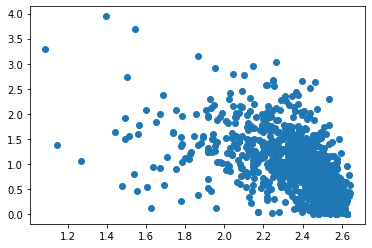

In [92]:
plt.scatter(np.absolute(labels)[0], np.absolute(labels)[1])

In [93]:
list(G.nodes)

['100monkeystyping.com',
 '12thharmonic.com/wordpress',
 '40ozblog.blogspot.com',
 '4lina.tblog.com',
 '750volts.blogspot.com',
 '95theses.blogspot.com',
 'abbadabbaduo.blogspot.com',
 'aboutpolitics.blogspot.com',
 'achingandspinning.blogspot.com',
 'ackackack.com',
 'adamtalib.blogspot.com',
 'adviceforlefty.blogspot.com',
 'agonist.org',
 'aintnobaddude.com',
 'ajbenjaminjr.blogspot.com',
 'alicublog.blogspot.com',
 'allanjenkins.typepad.com',
 'allspinzone.blogspot.com',
 'alphapredator.com/wdtgw.htm',
 'alternateworlds.blogspot.com',
 'althippo.blogspot.com',
 'alvintostig.typepad.com',
 'americablog.blogspot.com',
 'americablog.org',
 'americandreamslost.blogspot.com',
 'americanmuslim.blogs.com',
 'americanpolitics.com',
 'americansforbayh.blogspot.com',
 'amleft.blogspot.com',
 'amliberal.com/blog',
 'amptoons.com/blog',
 'anarchyxero.robfindlay.org',
 'andifeelfine.blogspot.com',
 'andymatic.com',
 'angrybear.blogspot.com',
 'angrydesi.typepad.com',
 'angryfinger.org',
 'angry

In [94]:
l = list(G.nodes)

In [95]:
l.index('liberaloasis.com')

362

In [96]:
l.index('liberalangst.org')

359

In [97]:
l.index('conservativessuck.blogspot.com')

141

In [98]:
l.index('conservativeblogger.com')

902

In [99]:
l.index('conservativenation.us')

909

In [100]:
l.index('conservativeresponse.com')

914

In [101]:
labels[:,362]

array([1.86455775, 3.14392692, 0.76561637, 0.66916516])

In [102]:
labels[:,359]

array([2.55295942, 0.34733931, 0.60516705, 0.44678158])

In [103]:
labels[:,141]

array([2.46565137, 0.3218959 , 0.23703704, 0.49523829])

In [104]:
labels[:,902]

array([2.56025119, 0.69966205, 0.65732146, 0.11761084])

In [105]:
labels[:,909]

array([2.58273958, 0.16058757, 0.3365258 , 0.51280878])

In [81]:
labels[:,914]

array([2.32565803, 0.40120961, 0.2636389 ])

In [88]:
sigmoid(np.real(output))

array([[0.02096127, 0.036792  , 0.00543431, ..., 0.00537405, 0.00360682,
        0.00538997],
       [0.036792  , 0.0878658 , 0.00590288, ..., 0.00568171, 0.00224845,
        0.0056784 ],
       [0.00543431, 0.00590288, 0.00477711, ..., 0.00510312, 0.00831587,
        0.00496538],
       ...,
       [0.00537405, 0.00568171, 0.00510312, ..., 0.00547275, 0.00930302,
        0.00531475],
       [0.00360682, 0.00224845, 0.00831587, ..., 0.00930302, 0.03354652,
        0.00903208],
       [0.00538997, 0.0056784 , 0.00496538, ..., 0.00531475, 0.00903208,
        0.00517313]])

In [85]:
M

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [86]:
output

array([[-3.84389463-2.55951006e-32j, -3.26498891-7.68438569e-33j,
        -5.20957431-5.89145291e-33j, ..., -5.22078558-5.57677169e-33j,
        -5.62131623-9.79300545e-33j, -5.21781149-7.78676149e-33j],
       [-3.26498891-7.68438569e-33j, -2.33997653-1.66383810e-32j,
        -5.126395  +3.38619270e-33j, ..., -5.16480583+3.17725018e-33j,
        -6.09526474+1.37596357e-32j, -5.16539127+2.50684303e-33j],
       [-5.20957431-5.89145291e-33j, -5.126395  +3.38619270e-33j,
        -5.33913158+2.35920226e-33j, ..., -5.27278754+3.50072422e-33j,
        -4.78123866+1.97719833e-33j, -5.30028678+1.82807871e-33j],
       ...,
       [-5.22078558-5.57677169e-33j, -5.16480583+3.17725018e-33j,
        -5.27278754+3.50072422e-33j, ..., -5.20248621+4.84611257e-33j,
        -4.66807012+3.27730898e-33j, -5.23193965+3.03448495e-33j],
       [-5.62131623-9.79300545e-33j, -6.09526474+1.37596357e-32j,
        -4.78123866+1.97719833e-33j, ..., -4.66807012+3.27730898e-33j,
        -3.3606999 -1.52731064e-33j

In [112]:
np.real(sigmoid(output))[909][904]

0.001149740424544718

In [113]:
np.real(sigmoid(output))[909][141]

0.0011653596603920426

In [114]:
np.real(sigmoid(output))

array([[0.01983964, 0.03001107, 0.0027673 , ..., 0.00260633, 0.00072801,
        0.00242025],
       [0.03001107, 0.05057741, 0.00309157, ..., 0.00306354, 0.00021533,
        0.00193788],
       [0.0027673 , 0.00309157, 0.00118356, ..., 0.00143396, 0.0041339 ,
        0.00153848],
       ...,
       [0.00260633, 0.00306354, 0.00143396, ..., 0.00183618, 0.00859157,
        0.00205751],
       [0.00072801, 0.00021533, 0.0041339 , ..., 0.00859157, 0.10892474,
        0.00471816],
       [0.00242025, 0.00193788, 0.00153848, ..., 0.00205751, 0.00471816,
        0.00169554]])